# The notebook is a workplace on the task of selfie-based estimation of skin type
Made by Roman Kiryanov, roman.kiryanov@skoltech.ru


## Initialization

### Preinstall required libraries

In [2]:
#!pip install dlib
#!pip install opencv-python
#!pip install --upgrade imutils

import dlib
import cv2

import numpy as np
import pandas as pd

import imutils
import os

from PIL import Image

from matplotlib import pyplot as plt

  Cloning https://github.com/siriusdemon/pytorch-pcn to /tmp/pip-req-build-7gjjf5_a
  Running command git clone -q https://github.com/siriusdemon/pytorch-pcn /tmp/pip-req-build-7gjjf5_a
  Stored in directory: /tmp/pip-ephem-wheel-cache-wngqc6l5/wheels/99/3b/30/d4e08639df962acfb6911f9b291f877d9a06e946926a317737
Successfully built pcn
OpenCV version 3.4.3


### Drive mounting for Data and Predictors upload

In [5]:
# mounting drive folder

from google.colab import drive
drive.mount('/content/gdrive') #, force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Masha's part of Data loading and Batch Generation
This is nearly total copy from masha's train.ipynb

In [52]:
# Path is place where 'Twins' folder with data and 2 files .dat for predictor

path = 'gdrive/My Drive/Colab Notebooks/DL_Project/'
datadir = path+'Twins'


metadata = pd.read_csv(f'{datadir}/image-metadata-2.0.csv')
# filter 
metadata = metadata[(metadata[' yaw']==0)&(metadata[' expression']!=' Happiness')&(metadata[' glasses']==' none')]
metadata['person_id'] = metadata['filename'].apply(lambda x: int(x.split('d')[0]))
metadata['view_id'] = metadata['filename'].apply(lambda x: x.split('d')[1].split('.')[0])
metadata.head()

,filename,date,gender,race,yearofbirth,weather,glasses,expression,yaw,Unnamed: 9,person_id,view_id
16,90003d17.nef,2009-08-08 00:00:00,Male,Black-or-African-American,1970,Inside,none,BlankStare,0,90003d17.nef,90003,17
17,90003d18.nef,2009-08-08 00:00:00,Male,Black-or-African-American,1970,Inside,none,BlankStare,0,90003d18.nef,90003,18
36,90003d40.nef,2009-08-08 00:00:00,Male,Black-or-African-American,1970,Inside,none,BlankStare,0,90003d40.nef,90003,40
38,90003d42.nef,2009-08-08 00:00:00,Male,Black-or-African-American,1970,Inside,none,BlankStare,0,90003d42.nef,90003,42
56,90003d60.nef,2009-08-08 00:00:00,Male,Black-or-African-American,1970,Rain,none,BlankStare,0,90003d60.nef,90003,60


In [0]:
# combine all views for a particular person
df_ids_views = metadata.groupby('person_id').view_id.apply(tuple).to_frame()

In [338]:
df_twins = pd.read_excel(f'{datadir}/twins-pairs_Fedor.xlsx', header=None).drop(columns=[2])
df_twins = df_twins[~df_twins[1].isnull()]
df_twins[1] = df_twins[1].astype(int)
df_twins.index = df_twins[0]
df_twins.head(10)

,0,1
0,,
90004,90004,90005
90008,90008,90009
90010,90010,90011
90012,90012,90013
90014,90014,90015
90016,90016,90017
90018,90018,90019
90021,90021,90022
90023,90023,90020


In [0]:
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid

In [0]:
class TwinDataset(Dataset):
    def __init__(self, dataroot, df, transform):
        '''
        dataroot: path to folder with items
        df: pandas dataframe with fields view, id_a, id_b
        transform: torchvision transform
        '''
        self.dataroot = dataroot
        self.df = df
        self.transform = transform
        
    def __getitem__(self, index):
        def get_img_path(img_id, view):
            return os.path.join(self.dataroot, f'{img_id}/{img_id}d{view}__face.jpg')
        
        views, id_a, id_b  = self.df.iloc[index].values
        
        view = np.random.choice(views)
#         print(view, id_a, id_b)
        path_a = get_img_path(id_a, view)
        path_b = get_img_path(id_b, view)
        
        img_a = Image.open(path_a)
        img_b = Image.open(path_b)
        
        if self.transform:
            img_a = self.transform(img_a)
            img_b = self.transform(img_b)
          
        
        return {'A': img_a, 'B': img_b, 'A_paths': path_a, 'B_paths': path_b }
    
    def __len__(self):
        return self.df.shape[0]

In [57]:
df_ids_views['twin'] = 0
df_ids_views['twin'].loc[df_twins.index] = df_twins[1]
df_ids_views = df_ids_views[df_ids_views.twin!=0]
df_train = pd.DataFrame(df_ids_views.view_id.values, columns = ['view_id'])
df_train['a'] = df_ids_views.index.values.astype(int)
df_train['b'] = df_ids_views.twin.values.astype(int)
df_train.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,view_id,a,b
0,"(17, 18, 40, 42, 60, 61, 83, 95, 98, 110, 114,...",90004,90005
1,"(17, 18, 40, 42, 60, 61, 83, 95, 98, 110, 115,...",90008,90009
2,"(17, 18, 40, 42, 60, 61)",90010,90011
3,"(17, 18, 40, 42, 60, 61)",90012,90013
4,"(17, 18, 40, 42, 60)",90014,90015


In [0]:
def check_exists(image_id_a, image_id_b, view_id, rootdir = f'{datadir}/nd-twins-0006/faces'):
    image_a = f'{image_id_a}d{view_id}.nef'
    image_b = f'{image_id_b}d{view_id}.nef'
    path1 = os.path.join(datadir, f'nd-twins-0006/faces/{image_id_a}/{image_id_a}d{view_id}__face.jpg')
    path2 = os.path.join(datadir, f'nd-twins-0006/faces/{image_id_b}/{image_id_b}d{view_id}__face.jpg')
    
    return os.path.exists(path1)&os.path.exists(path2)&\
                (image_a in metadata['filename'].values)&(image_b in metadata['filename'].values)

In [59]:
df_train['views_filtered'] = df_train.apply(lambda x: [view for view in x.view_id if check_exists(x.a,x.b,view) ], axis=1)
print(df_train.shape)
df_train['len'] = df_train['views_filtered'].apply(len)
df_train = df_train[df_train['len']>0]
print(df_train.shape)
df_train = df_train[['views_filtered', 'a', 'b']]
df_train.head()

(199, 4)
(158, 5)


,views_filtered,a,b
0,"[17, 18, 40, 42, 60, 61, 83, 95, 98, 110, 114,...",90004,90005
1,"[17, 18, 40, 42, 60, 61, 83, 95, 98, 110]",90008,90009
2,"[17, 18, 40, 42, 60, 61]",90010,90011
3,"[17, 18, 40, 42]",90012,90013
4,"[17, 18, 40, 42, 60]",90014,90015


In [0]:
class Args:
    batch_size = 1
    beta1 = 0.5
    checkpoints_dir = './_checkpoints'
    continue_train = False
    crop_size = 256
    dataroot = './datasets/facades' # skip              
    dataset_mode = 'aligned'
    direction = 'BtoA'                                 
    display_env = 'main'
    display_freq = 4  # html update frequency
    display_id = 1
    display_ncols = 4
    display_port = 8097
    display_server = '0.0.0.0'
    display_winsize = 256
    epoch = 'latest'
    epoch_count = 1
    gan_mode = 'vanilla'
    gpu_ids = [0] # device id
    init_gain = 0.02
    init_type = 'normal'
    input_nc = 3
    isTrain = True                                 
    lambda_L1 = 100.0
    load_iter = 0                                    
    load_size = 286
    lr = 0.0002
    lr_decay_iters = 50
    lr_policy = 'linear'
    max_dataset_size = float('inf')
    model = 'pix2pix'                              
    n_layers_D = 3
    name = 'twins_18_pix2pix' # name of experiment                     
    ndf = 64
    netD = 'basic'
    netG = 'unet_256'
    ngf = 64
    niter = 100
    niter_decay = 100
    no_dropout = False
    no_flip = False
    no_html = False
    norm = 'batch'
    num_threads = 4
    output_nc = 3
    phase = 'train'
    pool_size = 0
    preprocess = 'resize_and_crop'
    print_freq = 100
    save_by_iter = False
    save_epoch_freq = 5
    save_latest_freq = 5000
    serial_batches = False
    suffix = ''
    update_html_freq = 1000
    verbose = False
    isTrain = True

opt=Args()

In [0]:
df_train.to_csv(f'{datadir}/twins_sample_front_no_smile.csv', index=False)

In [0]:
from torchvision.transforms import Compose, Resize, Normalize, Normalize, ToTensor

resize = 256
mean=(0.485, 0.456, 0.406)
std=(0.229, 0.224, 0.225)

base_transform = Compose([Resize(resize),
                          ToTensor(),
                         Normalize(mean=mean, std=std)])

### Get dataset

In [0]:
twins_dataset = TwinDataset(f'{datadir}/nd-twins-0006/faces', df_train, base_transform)

In [0]:
dataset = DataLoader(twins_dataset,
            batch_size=opt.batch_size) #,shuffle=not opt.serial_batches)

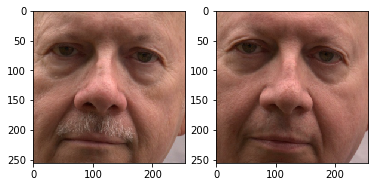

In [366]:
batch = next(iter(dataset))
fix, axs = plt.subplots(ncols=2)

img_A = batch['A'].squeeze().numpy().transpose(1,2,0)*std+mean
img_B = batch['B'].squeeze().numpy().transpose(1,2,0)*std+mean

axs[0].imshow(img_A)
axs[1].imshow(img_B)

## Get face landmark coordinates

In [0]:
from dlib_fd import dlib_landmark_detector

# Need this file and 2 .dat files
# Requires numpy, dlib, opencv

In [0]:
# initialize detector:
# cnn_flag = True to use CNN-based model.If False, use HOG-based model
# bb_detector_path = full path except name to bounding box detector (first stage of face detection)
# landmark_predictor_path = full path except name to 68-points trained weights for detector of face landmarks

dfd = dlib_landmark_detector(cnn_flag='True', 
                             bb_detector_path = path+'/mmod_human_face_detector.dat', 
                             landmark_predictor_path = path+'/shape_predictor_68_face_landmarks.dat' )

### One face

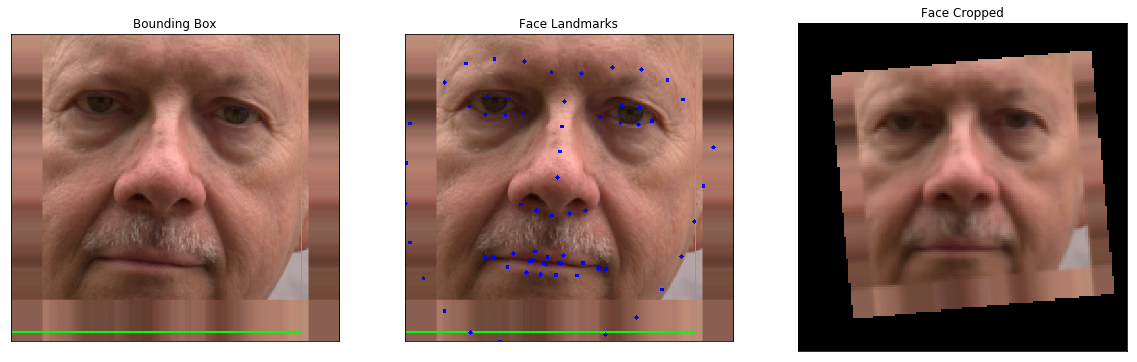

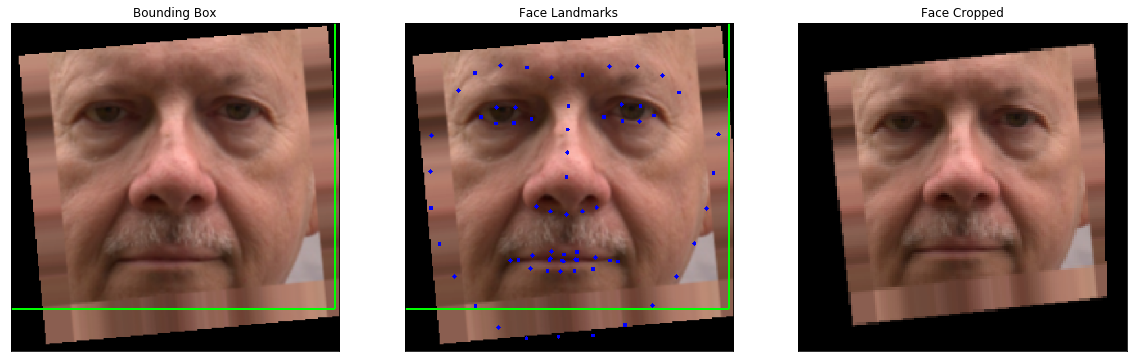

In [382]:
# HERE pass image
img = img_A


# Convert image from batch 'float64' to 'uint8'
img_8bit = (255*img/img.max() ).round().astype('uint8')

# Pad image with median values to "imitate" face surrounding and make jaw positioning correct
img_8bit_pad = np.pad(img_8bit, ((0,40),(30,30),(0,0)), mode='median')

# Reset detector
dfd.reset()

# Initialize detector with padded uint8 image. 
# To plot faces set flag visualize=True, if only doing work - visualize=False
dfd.face_detect(img_8bit_pad, visualize=True)

# Get 'centered', aligned and rotated image of face. Scale it to the same size as it was (256x256) with small padding
# Parameter of padding MUST be the same for ALL faces!!!!
face_cropped = dlib.get_face_chip(dfd._rescaled_image.copy(), dfd.landmark_shape, size=256, padding=0.15)


# Detect face but on rotated and aligned image.
dfd.reset()
dfd.face_detect(face_cropped, visualize=True)



# Finally, GET landmark coordinated as numpy array of [x, y] coords of each 68 point
img_shape = dfd.get_original_size_landmarks()

### Flipped face

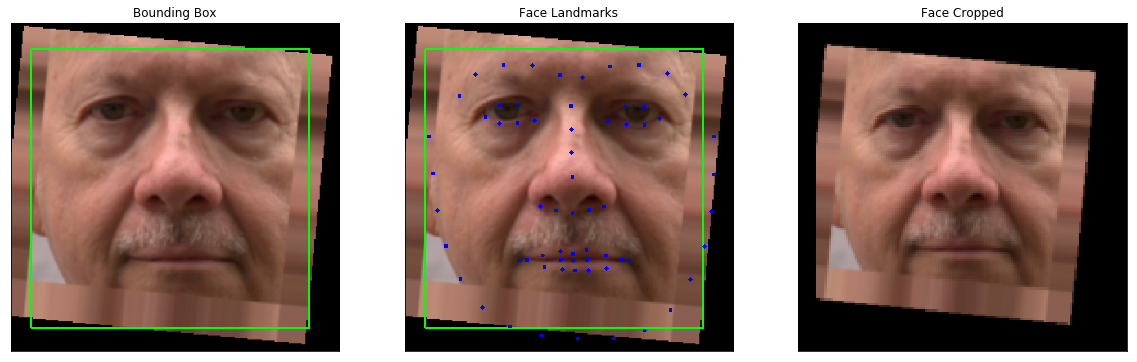

In [383]:
# Reset detector before start (like zero grads)
dfd.reset()

# get detection on flipped face
dfd.face_detect(np.flip(face_cropped, axis=1), visualize=True)


# Get landmark coordinates
img_FLIPPED_shape = dfd.get_original_size_landmarks()

### Second image in batch

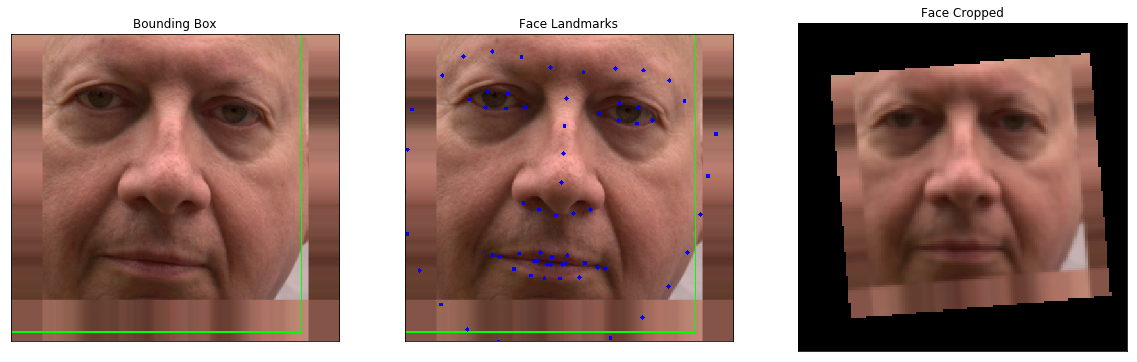

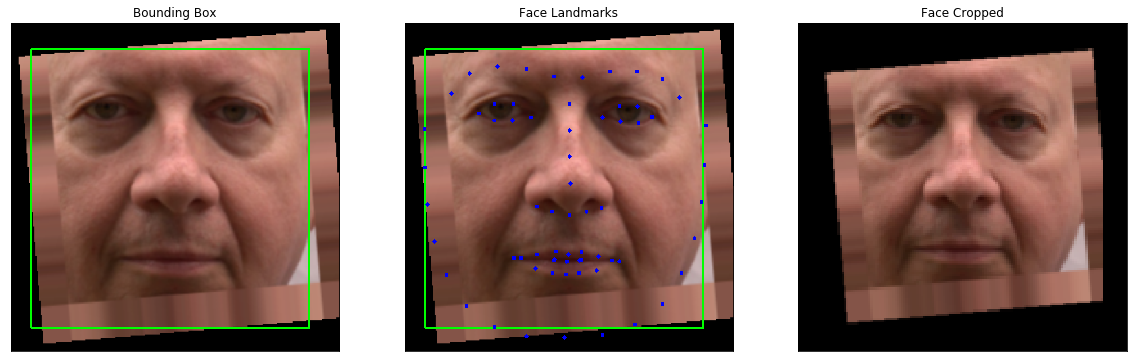

In [384]:
# HERE pass image and do the same for second image in batch
img = img_B

img_8bit = (255*img/img.max() ).round().astype('uint8')
img_8bit_pad = np.pad(img_8bit, ((0,40),(30,30),(0,0)), mode='median')


dfd.reset()
dfd.face_detect(img_8bit_pad, visualize=True)

face_cropped = dlib.get_face_chip(dfd._rescaled_image.copy(), dfd.landmark_shape, size=256, padding=0.15)

dfd.reset()
dfd.face_detect(face_cropped, visualize=True)

img_TWIN_shape = dfd.get_original_size_landmarks()

## Plot distances

In [0]:
def distance(shape1, shape2):
    return np.sqrt( np.power(shape1 - shape2, 2).sum(axis=1))

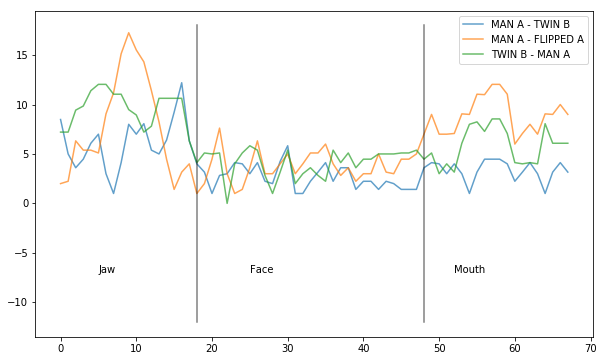

In [398]:
plt.figure(figsize=(10,6))

plt.plot( distance(img_shape, img_TWIN_shape),         alpha = 0.7, label = 'MAN A - TWIN B')
plt.plot( distance(img_FLIPPED_shape, img_shape),      alpha = 0.7, label = 'MAN A - FLIPPED A')
plt.plot( distance(img_TWIN_shape, img_FLIPPED_shape), alpha = 0.7, label = 'TWIN B - MAN A')

plt.plot(np.ones(10)*18,np.linspace(-12,18,10),'black',alpha=0.5)
plt.plot(np.ones(10)*48,np.linspace(-12,18,10),'black',alpha=0.5)
plt.legend()
plt.text(5,-7,'Jaw')
plt.text(25,-7,'Face')
plt.text(52,-7,'Mouth')
plt.show()

### Old version

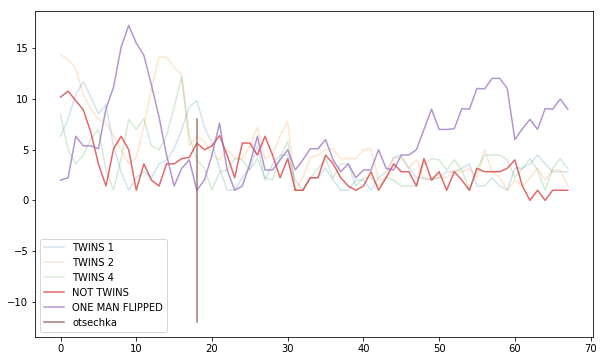

In [381]:
plt.figure(figsize=(10,6))

#plt.plot(imgB_shape[:,0] - imgA_shape[:,0], 'r', alpha = 0.5, label = 'TWINS 1: X')
#plt.plot(imgB_shape[:,1] - imgA_shape[:,1], label = 'TWINS 1: Y')

#plt.plot(imgB_shape_NEW[:,0] - imgA_shape_NEW[:,0],label = 'TWINS 2: X')
#plt.plot(imgB_shape_NEW[:,1] - imgA_shape_NEW[:,1], label = 'TWINS 2: Y')

plt.plot(np.sqrt( np.power(imgB_shape - imgA_shape, 2).sum(axis=1) ), alpha = 0.2, label = 'TWINS 1')
plt.plot(np.sqrt( np.power(imgB_shape_NEW - imgA_shape_NEW, 2).sum(axis=1) ), alpha = 0.2, label = 'TWINS 2')
#plt.plot(np.sqrt( np.power(imgB_shape_3 - imgA_shape_3, 2).sum(axis=1) ), alpha = 0.2, label = 'TWINS 3')
plt.plot(np.sqrt( np.power(imgB_shape_4 - imgA_shape_4, 2).sum(axis=1) ), alpha = 0.2, label = 'TWINS 4')

plt.plot(np.sqrt( np.power(imgB_shape_4 - imgA_shape_3, 2).sum(axis=1) ), alpha = 0.7, label = 'NOT TWINS')
plt.plot(np.sqrt( np.power(imgA_shape_4 - imgA_shape_4_FLIP, 2).sum(axis=1) ), alpha = 0.7, label = 'ONE MAN FLIPPED')

plt.plot(np.ones(10)*18,np.linspace(-12,8,10), alpha=0.8, label='otsechka')
plt.legend()
plt.show()